Writing cache file for status plot
Status plot created


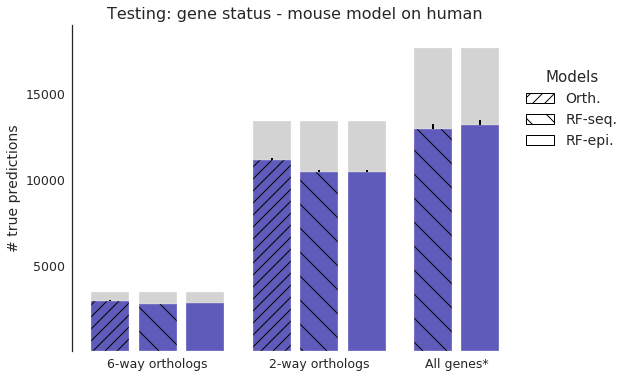

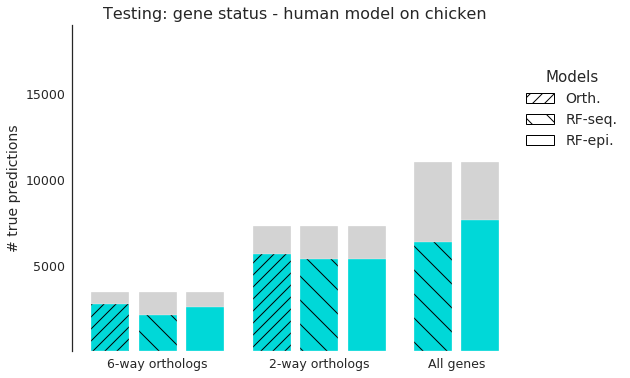

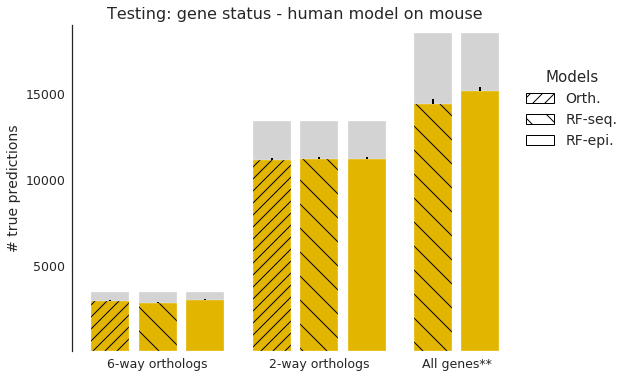

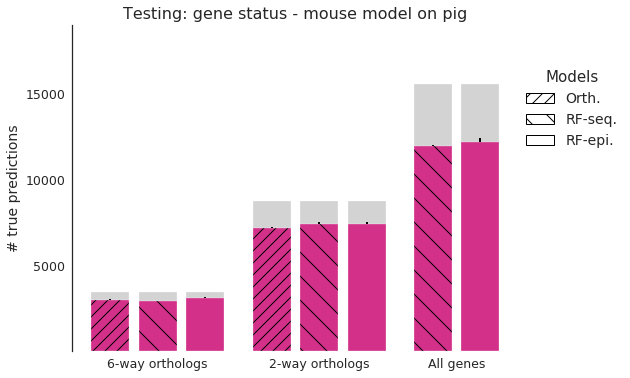

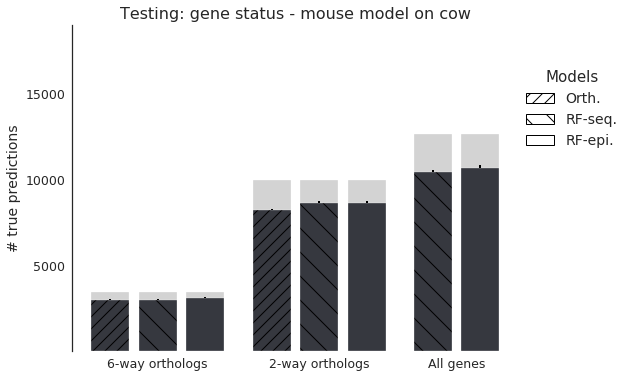

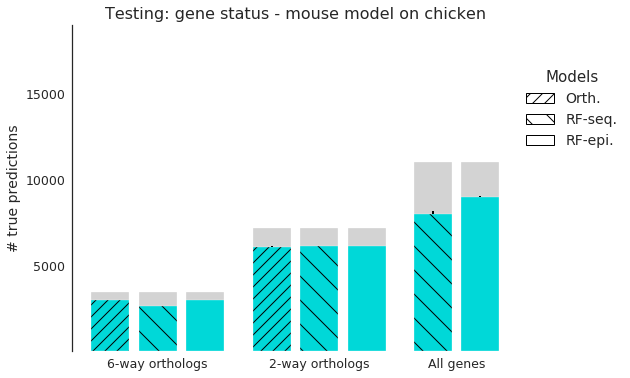

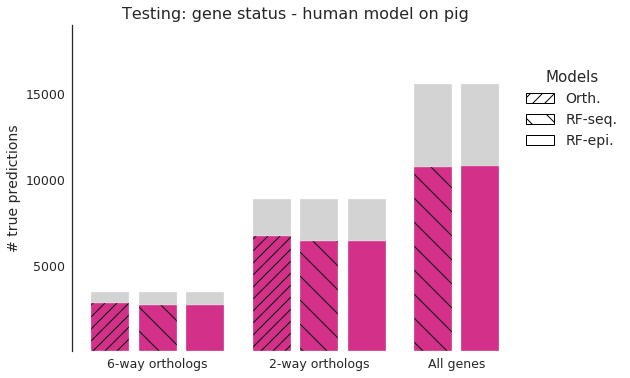

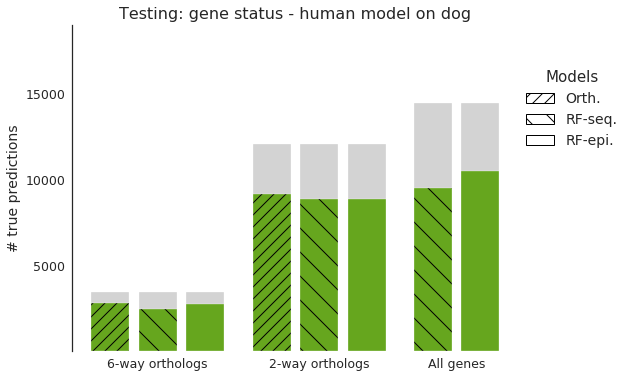

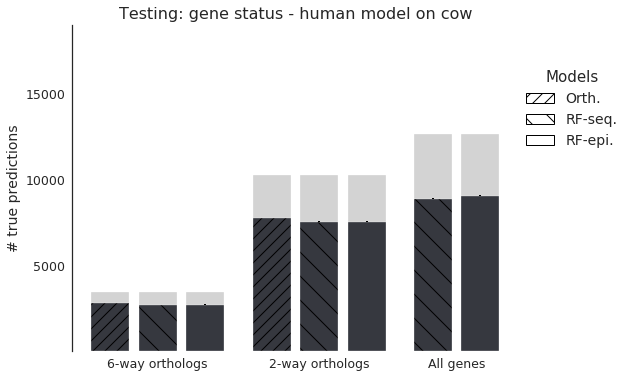

In [8]:
%matplotlib inline

import os as os
import numpy as np
import numpy.random as rng
import json as js
import pickle as pck
import collections as col
import operator as op
import functools as fnt
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy.stats import mannwhitneyu as mwu

sns.set(style='white',
        font_scale=1.25,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis'
stat_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_summarize')
stat_file = os.path.join(stat_folder, 'agg_expstat_est.h5')
ortho_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_ortho_pred')
ortho_pred = os.path.join(ortho_folder, 'orthopred_odb_6species.h5')

cache_dir = '/home/pebert/.jupyter/cache'

conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'

plot_labels = js.load(open(os.path.join(conf_folder, 'labels', 'cs_labels.json'), 'r'))
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))
plot_shapes = js.load(open(os.path.join(conf_folder, 'shapes', 'cs_shapes.json'), 'r'))

run_exec_status = True

show_figures = True
use_hatched_bars = True

out_folder = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/crossspecies/figures/pub'
save_figures = True

def exec_status():
    cache_data = os.path.join(cache_dir, 'plot_perf_status.pck')
    if not run_exec_status:
        return False
    if os.path.isfile(cache_data):
        model_perf = pck.load(open(cache_data, 'rb'))
    else:
        model_perf = collect_ortho_perf(ortho_pred, 'status')
        model_perf = collect_model_stat_perf(stat_file, model_perf, 'pos', 'seq')
        model_perf = collect_model_stat_perf(stat_file, model_perf, 'pos', 'asig')
        with open(cache_data, 'wb') as out:
            print('Writing cache file for status plot')
            pck.dump(model_perf, out)
    for (spec_a, spec_b), perf in model_perf.items():
        if spec_a == 'mouse' and spec_b == 'dog':
            continue
        bar_labels = ['Orth.', 'RF-seq', 'RF-epi',
                      'Orth.', 'RF-seq', 'RF-epi',
                      'RF-seq', 'RF-epi']
        if spec_a in ['human', 'mouse'] and spec_b in ['human', 'mouse']:
            x = perf['data_crp_seq_all']
            y = perf['data_crp_asig_all']
            _, pv = mwu(x, y, alternative='less')
            if pv < 0.0001:
                group_labels = ['6-way orthologs', '2-way orthologs', 'All genes***']
            elif pv < 0.001:
                group_labels = ['6-way orthologs', '2-way orthologs', 'All genes**']
            elif pv < 0.01:
                group_labels = ['6-way orthologs', '2-way orthologs', 'All genes*']
            else:
                group_labels = ['6-way orthologs', '2-way orthologs', 'All genes']
        else:
            group_labels = ['6-way orthologs', '2-way orthologs', 'All genes']
        bar_color = plot_colors['species'][spec_b]['rgb']
        max_values = [perf['max_group'], perf['max_group'], perf['max_group'],
                      perf['max_pair'], perf['max_pair'], perf['max_pair'],
                      perf['max_all'], perf['max_all']]
        data_values = [perf['data_orth_group'], perf['data_crp_seq_group'], perf['data_crp_asig_group'],
                       perf['data_orth_pair'], perf['data_crp_asig_pair'], perf['data_crp_asig_pair'],
                       perf['data_crp_seq_all'], perf['data_crp_asig_all']]        
        plot_title = 'Testing: gene status - {} model on {}'.format(spec_a, spec_b)
        fig, exart = plot_perf_barchart(max_values, data_values, plot_title,
                                        bar_labels, bar_color, group_labels, '# true predictions')

        if save_figures:
            outpath = os.path.join(out_folder, 'main', 'fig_X_main_{}-to-{}_testperf_status.svg'.format(spec_a, spec_b))
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
            outpath = outpath.replace('.svg', '.png')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)
    return True
       

def plot_perf_barchart(maxvals, datavals, title, barlabels, barcolor, grouplabels, ylabel):
    """
    """
    first_xloc = 0.2
    bar_width = 0.2
    coords = get_xlocs(first_xloc, bar_width, 3, [3, 3, 2])
    
    get_rf_seq = op.itemgetter(*(1, 4, 6))
    get_rf_epi = op.itemgetter(*(2, 5, 7))
    get_orth = op.itemgetter(*(0, 3))
    
    zero_std = np.zeros(len(maxvals))
    
    fig, ax = plt.subplots(figsize=(8, 6))
    extra_artists = []
    ax.set_xlim(0, coords['x_end'])
    ax.set_ylim(0, 19000)
    ax.set_yticks([5000, 10000, 15000])
   
    xtick_loc = [coords['group_mids'][0], coords['group_mids'][1], coords['group_mids'][2]]
    xtick_loc = [f - 0.1 for f in xtick_loc]
    ax.set_xticks(xtick_loc)
    ax.set_xticklabels(grouplabels)

    # plot light grey background for max values
    bg_rects = ax.bar(coords['bar_xlocs'], maxvals, bar_width,
                      color='lightgrey', yerr=[zero_std, zero_std],
                      edgecolor='white')
    
    fg_stds = []
    for values in datavals:
        if len(values) <= 2:
            fg_stds.append(0)
        else:
            fg_stds.append(np.std(values))
    fg_means = [np.round(np.mean(v),0) for v in datavals]
        
    fg_orth = ax.bar(get_orth(coords['bar_xlocs']), get_orth(fg_means) , bar_width,
                     color=barcolor, yerr=[get_orth(zero_std), get_orth(fg_stds)],
                     edgecolor='white', hatch='//',
                     error_kw=dict(ecolor='black', capsize=7, capthick=0,
                                     lw=2))
    
    fg_rf_seq = ax.bar(get_rf_seq(coords['bar_xlocs']), get_rf_seq(fg_means), bar_width,
                       color=barcolor, yerr=[get_rf_seq(zero_std), get_rf_seq(fg_stds)],
                       edgecolor='white', hatch='\\',
                       error_kw=dict(ecolor='black', capsize=7, capthick=0,
                                     lw=2))
    
    fg_rf_epi = ax.bar(get_rf_epi(coords['bar_xlocs']), get_rf_epi(fg_means), bar_width,
                       color=barcolor, yerr=[get_rf_epi(zero_std), get_rf_epi(fg_stds)],
                       edgecolor='white', hatch='',
                       error_kw=dict(ecolor='black', capsize=7, capthick=0,
                                     lw=2))

    rf_seq_leg = mpatches.Patch(facecolor='white', label='RF-seq.',
                                hatch='\\', edgecolor='black',
                                ls='solid', lw=1)
    rf_epi_leg = mpatches.Patch(facecolor='white', label='RF-epi.',
                                hatch='', edgecolor='black',
                                ls='solid', lw=1)
    orth_leg = mpatches.Patch(facecolor='white', label='Orth.',
                            hatch='//', edgecolor='black',
                            ls='solid', lw=1)
    model_handles = [orth_leg, rf_seq_leg, rf_epi_leg]

    leg_models = plt.legend(handles=model_handles, loc=1, title='Models',
                            markerscale=1.5, fontsize=14, bbox_to_anchor=(1.25, 0.9))
    extra_artists.append(leg_models)
    
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    return fig, extra_artists


def get_xlocs(start_value, bar_width, num_groups, group_bars):
    """
    """
    bar_space = 0.05
    group_skip = 0.15
    bar_xlocs, bar_mids = [], []
    last_xloc = start_value
    group_coords = col.defaultdict(dict)
    for gidx, num_bars in zip(range(num_groups), group_bars):
        if gidx == 0:
            group_coords[0]['start'] = last_xloc
        else:
            group_coords[gidx - 1]['end'] = last_xloc
            last_xloc += group_skip
            group_coords[gidx]['start'] = last_xloc
        
        for bidx in range(num_bars):
            bar_xlocs.append(last_xloc)
            bar_mid = last_xloc + bar_width / 2.
            bar_mids.append(bar_mid)
            last_xloc += bar_width
            last_xloc += bar_space
        last_xloc -= bar_space
    group_coords[num_groups - 1]['end'] = last_xloc
    group_mids = []
    for g in sorted(group_coords.keys()):
        s, e = group_coords[g]['start'], group_coords[g]['end']
        group_mids.append(s + (e - s) / 2.)
    result = {'bar_xlocs': bar_xlocs, 'bar_mids': bar_mids,
              'group_mids': group_mids, 'x_end': last_xloc}
    return result


def collect_ortho_perf(fpath, which):
    """
    """
    rk_consistency = 'perf_num_consistent_act_5'
    collector = dict()
    with pd.HDFStore(fpath, 'r') as hdf:
        load_keys = [k for k in hdf.keys() if k.startswith('/pos/pair') and k.endswith('/metadata')]
        for k in load_keys:
            if any([c in k for c in ['GM12878', 'CH12', 'K562', 'MEL']]):
                continue
            parts = k.split('/')
            spec_a, spec_b = parts[3], parts[4]
            md = hdf[k]
            max_val = int(md.loc['num_orthologs', :][0])
            if which == 'status':
                true_pred = int(md.loc['perf_num_tp',:][0]) + int(md.loc['perf_num_tn',:][0])
            elif which == 'rank':
                raise RuntimeError('Rank plot deprecated')
                true_pred = int(md.loc[rk_consistency, :][0])
            else:
                raise ValueError('Unknown setting requested: {}'.format(which))
            if (spec_a, spec_b) not in collector:
                collector[(spec_a, spec_b)] = {'max_pair': max_val, 'data_orth_pair': [true_pred],
                                               'max_group': 0, 'data_orth_group': [], 'max_all': 0,
                                               'data_crp_seq_pair': [], 'data_crp_seq_group': [],
                                               'data_crp_seq_all': [],
                                               'data_crp_asig_pair': [], 'data_crp_asig_group': [],
                                               'data_crp_asig_all': []}
            else:
                collector[(spec_a, spec_b)]['data_orth_pair'].append(true_pred)
        load_keys = [k for k in hdf.keys() if k.startswith('/pos/group') and k.endswith('/metadata')]
        for k in load_keys:
            parts = k.split('/')
            spec_a, spec_b = parts[3], parts[4]
            md = hdf[k]
            max_val = int(md.loc['num_orthologs', :][0])
            if which == 'status':
                true_pred = int(md.loc['perf_num_tp',:][0]) + int(md.loc['perf_num_tn',:][0])
            elif which == 'rank':
                true_pred = int(md.loc[rk_consistency])
            else:
                raise ValueError('Unknown setting requested: {}'.format(which))
            collector[(spec_a, spec_b)]['data_orth_group'].append(true_pred)
            collector[(spec_a, spec_b)]['max_group'] = max_val
    return collector


def collect_model_stat_perf(fpath, data_collect, scenario, model):
    """
    """
    with pd.HDFStore(fpath, 'r') as hdf:
        load_keys = [k for k in hdf.keys() if k.startswith('/'.join(['', scenario, model])) and k.endswith('/metadata')]
        for k in load_keys:
            if any([c in k for c in ['GM12878', 'CH12', 'K562', 'MEL']]):
                continue
            md = hdf[k]
            spec_a = md.loc['target_spec',:][0]
            spec_b = md.loc['query_spec',:][0]            
            if (spec_a, spec_b) not in data_collect:
                data_collect[(spec_a, spec_b)] = {'max_all': 0,
                                                  'data_crp_{}_pair'.format(model): [],
                                                  'data_crp_{}_group'.format(model): [],
                                                  'data_crp_{}_all'.format(model): []}
                
            num_samples_all = int(md.loc['perf_wg_num_active',:][0]) + int(md.loc['perf_wg_num_inactive',:][0])
            true_pred_all = int(md.loc['perf_wg_true',:][0])
            true_pred_pair = int(md.loc['perf_pair_true',:][0])
            true_pred_grp = int(md.loc['perf_group_true',:][0])
            data_collect[(spec_a, spec_b)]['max_all'] = num_samples_all
            data_collect[(spec_a, spec_b)]['data_crp_{}_pair'.format(model)].append(true_pred_pair)
            data_collect[(spec_a, spec_b)]['data_crp_{}_group'.format(model)].append(true_pred_grp)
            data_collect[(spec_a, spec_b)]['data_crp_{}_all'.format(model)].append(true_pred_all)
    return data_collect


execd = exec_status()
if execd:
    print('Status plot created')
